In [1]:
!pip install timm einops
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.6.3/flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl
!pip install --no-dependencies --upgrade flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 91.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import torch
import torchvision.transforms as T
# from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [4]:
# model_name = "5CD-AI/Vintern-1B-v2"
model_name = "5CD-AI/Vintern-1B-v3_5"

In [5]:
try:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True,
      use_flash_attn=False,
  ).eval().cuda()
except:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True
  ).eval().cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

configuration_internvl_chat.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

modeling_intern_vit.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


conversation.py:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v3_5:
- modeling_internvl_chat.py
- modeling_intern_vit.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


FlashAttention2 is not installed.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

tokenizer_config.json:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
!wget https://quynhontourist.com/wp-content/uploads/2021/03/ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg
!wget https://images6.alphacoders.com/519/thumb-1920-519777.jpg

--2025-05-21 11:03:21--  https://quynhontourist.com/wp-content/uploads/2021/03/ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg
Resolving quynhontourist.com (quynhontourist.com)... 103.221.223.46
Connecting to quynhontourist.com (quynhontourist.com)|103.221.223.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166523 (163K) [image/jpeg]
Saving to: ‘ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg’

ho-so-nang-luc-quy- 100%[===================>] 162.62K   325KB/s    in 0.5s    

2025-05-21 11:03:22 (325 KB/s) - ‘ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg’ saved [166523/166523]

--2025-05-21 11:03:23--  https://images6.alphacoders.com/519/thumb-1920-519777.jpg
Resolving images6.alphacoders.com (images6.alphacoders.com)... 104.20.75.132, 172.67.48.187, 104.20.76.132, ...
Connecting to images6.alphacoders.com (images6.alphacoders.com)|104.20.75.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 573387 (560K) [image/jpe

In [8]:
import matplotlib.pyplot as plt
import glob

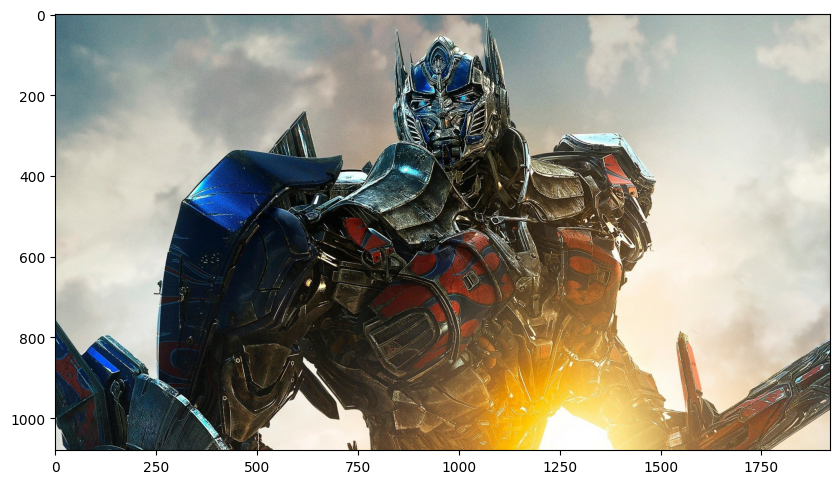

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: Mô tả hình ảnh một cách chi tiết trả về dạng markdown.
Assistant: # Mô tả hình ảnh: Một nhân vật robot lớn

Hình ảnh cho thấy một nhân vật robot khổng lồ, có vẻ ngoài mạnh mẽ và quyền lực.  Robot có màu sắc chủ đạo là xanh dương đậm, kết hợp với các chi tiết màu đỏ và cam tạo nên sự tương phản mạnh mẽ.  Thiết kế của robot bao gồm nhiều bộ phận phức tạp, thể hiện kỹ thuật chế tạo cao cấp.  Phần thân chính của robot được làm từ chất liệu kim loại hoặc thép không gỉ, mang lại cảm giác cứng cáp và chắc chắn.  Các cánh tay và chân cũng được thiết kế tỉ mỉ, thể hiện sự linh hoạt và khả năng di chuyển nhanh chóng.  Trên đầu robot đội một chiếc mũ bảo hiểm bằng kim loại sáng bóng.  Hình ảnh được chụp vào lúc hoàng hôn, với ánh sáng vàng rực rỡ chiếu xuống phần thân robot, tạo nên hiệu ứng lung linh và huyền bí.

**Thông tin bổ sung:**
* **Tên:** (Không có trong ảnh)
* **Đặc điểm nổi bật:** Robocop
* **Thiết kế:** Kỹ thuật số cao cấp
* **Màu sắc:** Xanh dương, đỏ, cam
* **Chất liệu:** Kim

In [12]:
test_image = "thumb-1920-519777.jpg"
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens= 512, do_sample=False, num_beams = 3, repetition_penalty=3.5)

question = 'Mô tả hình ảnh một cách chi tiết trả về dạng markdown.'

response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

In [20]:
from IPython.display import Audio, display, clear_output
import time
import ipywidgets as widgets
import os

os.makedirs('images', exist_ok=True)

In [31]:
def chat():
    conversation = ""
    # Create chat interface
    prompt_widget = widgets.Text(
        value='',
        placeholder='Type your prompt (e.g., Describe image1.jpg and image2.jpg)',
        description='You:',
        layout={'width': '500px'}
    )
    submit_button = widgets.Button(
        description='Submit',
        button_style='primary',
        tooltip='Click to submit prompt'
    )

    image_upload = widgets.FileUpload(
        accept='.jpg,.jpeg,.png,.gif,.bmp',
        multiple=False,
        description='Image'
    )
    output = widgets.Output()

    def on_submit(button):
        nonlocal conversation
        with output:
            prompt = prompt_widget.value.strip()
            if prompt.lower() == 'exit':
                print("Chat ended.")
                return
            prompt_widget.value = ''  # Clear input after submission

            if len(image_upload.value) > 0:
                image_name = image_upload.value[0]['name']
                image_content = image_upload.value[0]['content']
                img_path = f'images/{image_name}'
                with open(img_path, 'wb') as f:
                    f.write(image_content)
                image_upload.value = ()
                
                plt.figure(figsize=(10,10))
                plt.imshow(Image.open(img_path))
                plt.show()
                pixel_values = load_image(img_path, max_num=6).to(torch.bfloat16).cuda()
            else:
                pixel_values = None

            convesration =  conversation + '<usr>' + prompt + "</usr>"
            generation_config = dict(max_new_tokens= 512, do_sample=False, num_beams = 3, repetition_penalty=3.5)
            
            response = model.chat(tokenizer, pixel_values, conversation, generation_config)
            print(f'User: {prompt}\nAssistant: {response}')
            conversation = conversation + '<sys>' + response.lower() + '</sys>'


    submit_button.on_click(on_submit)
    display(widgets.VBox([image_upload, prompt_widget, submit_button, output]))

In [32]:
chat() # the model wasn't finetuned for chatting